In [9]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import time
import multiprocessing
from higashi import get_scc2
import pandas as pd
import hypernetx as hnx
from tqdm import tqdm
from math import pow

In [10]:
def get_Multiple_interactions_MC(chr_key, scSCRIPE_dir, files, re, chr):
    Multiple_interactions = {}
    idx = 0
    for file in tqdm(files):
        f = open(scSCRIPE_dir + '\\' + file, 'r', encoding='utf-8')
        i = 0
        while True:
            line = f.readline()
            if not line:
                break;
            a = line.strip().split()
            if len(a) < 3:
                continue
            del a[0]

            b = []
            for obj in a:
                if len(chr_key) <= 4:
                    if obj[:5] == chr_key + ':' and int(obj[5:]) <= chr:
                        b.append(str(int(obj[5:]) // re))  # 取100k为分辨率
                        i += 1
                else:
                    if obj[:6] == chr_key + ':' and int(obj[6:]) <= chr:
                        b.append(str(int(obj[6:]) // re))  # 取100k为分辨率
                        i += 1
            b = list(set(b))
            if not b or len(b) < 2:
                continue
            if len(b) >= 1000: continue
            Multiple_interactions[idx] = b
            idx += 1
        f.close()
    print(idx)
    return Multiple_interactions


def get_raw(chr, re, Multiple_interactions):
    raw_output = np.zeros((chr // re + 1, chr // re + 1))
    for edge in Multiple_interactions.keys():
        if len(Multiple_interactions[edge]) >= 100: continue
        for bin1, bin2 in combinations(Multiple_interactions[edge], 2):
            raw_output[int(bin1)][int(bin2)] += 1
            raw_output[int(bin2)][int(bin1)] += 1
    return raw_output


def hypergraph_build(Multiple_interactions):
    Multiple_interactions_hypergraph = hnx.Hypergraph(Multiple_interactions)
    return Multiple_interactions_hypergraph

def get_file_name(file_dir):
    L = []
    for root, dirs, files in os.walk(file_dir):
        for file in files:
            L.append(file)
    return L

def randomfile(file_dir, r):
    scSCRIPE_dir = file_dir + '\\filtered_1000_cells_single_cell_files'
    files = get_file_name(scSCRIPE_dir)
    np.random.shuffle(files)
    if r >= len(files): r = len(files)
    return files[:r]

def get_mat(file_dir, chr_key, files, re, chr):
    scSCRIPE_dir = file_dir + '\\filtered_1000_cells_single_cell_files'
    Multiple_interactions = get_Multiple_interactions_MC(chr_key, scSCRIPE_dir, files, re, chr)
    raw_mat = get_raw(chr, re , Multiple_interactions)
    return raw_mat
def main():
    files = randomfile("D:\\dataset", 1000)
    mat = get_mat('D:\\dataset', 'chr1', files, 100000, 197195432)
    return mat



In [11]:
mat = main()


100%|██████████| 1000/1000 [01:00<00:00, 16.47it/s]


247025


In [84]:
np.savetxt('raw_all_100000.matrix', mat, delimiter = "\t", fmt = "%1f")

In [12]:
a = np.array(mat)

In [26]:
np.savetxt('raw_all_500000.matrix', a)

In [56]:
from scipy.stats import pearsonr, zscore
import scipy
def pearson_score(m1, m2):
    return pearsonr(m1.reshape((-1)), m2.reshape((-1)))[0]
def zscore_norm(matrix):
    v = matrix.reshape((-1))
    if not (v == v[0]).all():
        matrix = zscore(v).reshape((len(matrix), -1))
    return matrix

def Result_record(file_dir, chr_key, file):
    chr_dir = file_dir + '/' + file + '/' + chr_key + '/' + file + '_' + chr_key + '.npz'
    if os.path.isfile(chr_dir):
        return True
    return False
def Result_record2(file_dir, chr_key, file, re):
    chr_dir = file_dir + '/' + file + '/' + chr_key + '/' + file + '_' + chr_key + '_' + str(re) + '.npz'
    if os.path.isfile(chr_dir):
        return True
    return False

def get_rawandout(file, file_dir, chr_key, re, type):
    #100kb
    o_dir = file_dir + '/' + file + '/' + chr_key + '/' + file + '_' + chr_key + '_' + str(re)  + type
    r_dir = file_dir + '/' + file + '/' + chr_key + '/' + 'raw_' + chr_key + '_' + str(re)  + type
    #print(o_dir)
    if type == '.matrix.gz':
        raw = np.loadtxt(r_dir)
        node = np.loadtxt(o_dir)
        return raw, node
    elif type == '.npz':
        raw = scipy.sparse.load_npz(r_dir)
        node = scipy.sparse.load_npz(o_dir)
        return raw, node
    return #print('error : get none mat')
def get_mat2(file_dir, files, chr, re, type):
    '''
    :param chr:
    :param num:
    :param re:
    :param type:.npz'
    :param output_dir:
    :return:
    '''
    HiC_dir = file_dir + '/HiC_node2vec'
    chr_key = chr
    if Result_record2(HiC_dir, chr_key, files[0] ,re):
        raw, node = get_rawandout(files[0], HiC_dir, chr_key, re, type)
        raw = raw.todense()
        node = node.todense()
        return raw, node
    '''if len(files) > 1 :
        for file in tqdm(files[1:]):
            if Result_record(HiC_dir, chr_key, file):
                r, n = get_rawandout(file, HiC_dir, chr_key, re, type)
        if node.shape == n.shape:
            raw = raw + r
            node = node + n
    if type == '.npz':
        raw1 = raw.todense()
        node = node.todense()'''



def get_file_name(file_dir):
    L = []
    for root, dirs, files in os.walk(file_dir):
        for file in files:
            L.append(file)
    return L


def randomfile(file_dir, r):
    scSCRIPE_dir = file_dir + '\\filtered_1000_cells_single_cell_files'
    files = get_file_name(scSCRIPE_dir)
    #np.random.shuffle(files)
    return files[:r]

In [ ]:
def get_int(value, chr, re):
    if value[:5] == chr + ':':
        return (value[:4], int(int(value[5:-2])//re), value[-1:])

def get_d_value(v1, v2, v3, v4, mat):
    sum = np.sum(mat[v1:v2, v1:v2]) + np.sum(mat[v2:v3, v2:v3]) + np.sum(mat[v3:v4, v3:v4]) + np.sum(mat[v1:v2, v3:v4]) * 2
    sum2 = np.sum(mat[v2:v3, v3:v4]) * 2 + np.sum(mat[v2:v3, v1:v2]) * 2
    score = sum / ((v4 - v1) ** 2 - ((v3 - v2) * (v4 - v3) * 2 + (v3 - v2) * (v2 - v1) * 2)) - sum2 / ((v3 - v2) * (v4 - v3) * 2 + (v3 - v2) * (v2 - v1) * 2)
    return score

def get_d_value2(v1, v2, v3, v4, mat):
    sum = np.sum(mat[v1:v2, v1:v2]) + np.sum(mat[v2:v3, v2:v3]) + np.sum(mat[v3:v4, v3:v4]) + np.sum(mat[v1:v2, v3:v4]) * 2
    sum2 = np.sum(mat[v2:v3, v3:v4]) * 2 + np.sum(mat[v2:v3, v1:v2]) * 2
    score = (sum - sum2) / (v4 - v1) ** 2
    return score



def get_cp_score(mat, data, chr, re):
    value = []
    l = []
    for item in np.array(data):
        a = item.strip().split(',')
        value.append(get_int(a[0], chr, re))
    data1 = pd.DataFrame(value, index=data.index, columns=['chr', 'pos', 'cp'], dtype=int)
    data1 = data1[~(data1['pos'].isnull())]
    for t in range(1, len(data1) - 2):
        va =get_d_value2(int(data1['pos'].loc[t - 1]), int(data1['pos'].loc[t]), int(data1['pos'].loc[t + 1]), int(data1['pos'].loc[t + 2]), mat)
        l.append(va)
    return np.array(l)
data = pd.read_csv('C:\\Users\lenovo\Downloads\\cp.txt', skiprows=1,sep='\t',header=None, encoding='gbk')
data = data[1]
file_dir = "D:\\dataset"

files = randomfile("D:\\dataset", 1000)

output = pd.DataFrame(columns=['cell', 'raw', 'node'])
for i in tqdm(range((len(files)))):
    file = files[i]
    HiC_dir = 'D:/dataset' + '/lym/HiC_node2vec'
    if Result_record(HiC_dir, 'chr1', file):
        raw, node = get_mat2(file_dir, [file], 'chr1' , 100000, '.npz')
        raw[(raw > 1)] = 1
        '''node[(node > 0.8)] = 1
        node[(node < 0.7)] = 0'''
        output.loc[i] = list((file, get_cp_score(raw, data, 'chr1', re=100000), get_cp_score(node, data, 'chr1', re=100000)))


In [44]:
data_tad = pd.read_csv('C:\\Users\lenovo\Downloads\\tad.txt',sep='\t',header=None, encoding='gbk')
pos = data_tad.loc[149, 2]
data_tad = data_tad[1]
data_tad.loc[len(data_tad.index)] = pos
data_tad = data_tad.tolist()

In [144]:
def get_pos(data, i):
    pos1 = 0
    pos2 = len(data) - 1
    while pos1 < i and pos2 > i:
        if data[i] - data[pos1 + 1] >= 1000000:
            pos1 += 1
        if data[pos2 - 1] - data[i] >= 1000000:
            pos2 -= 1
        if data[i] - data[pos1 + 1] < 1000000 and data[pos2 - 1] - data[i] < 1000000:break
    return pos1, pos2
def get_mat_score(mat, pos1, pos2, data, pos):
    value1 = value2 = 0
    sum1 = sum2 = 0
    for i in range(pos1 + 1, pos2):
        x = data[i] // 40000 - data[pos] // 40000 + 25
        if i == pos1 + 1:
            value1 += np.sum(mat[:x, :x])
            sum1 += ((x + 1) * (x + 1))
            value2 += np.sum(mat[:x, x:-1]) * 2
            sum2 += ((x + 1) * (49 - x) * 2)
        if i == pos2 - 1:
            value1 += np.sum(mat[x:, x:])
            sum1 += (49 - x) * (49 - x)
        if i > pos1 + 1 and i <= pos2 - 1:
            y = data[i - 1] // 40000 - data[pos] // 40000 + 25
            value1 += np.sum(mat[y:x, y:x])
            sum1 += ((x - y)* (x - y))
            value2 += np.sum(mat[y:x, x:-1]) * 2
            sum2 += ((x - y) * (49 - x) * 2)
    if sum1  and sum2:
        value = (value1 - value2)/ 2500
        return  value
    else:
        return 0
def get_tad_score(mat, data):
    l = []
    for i in range(1, len(data) - 1):
        pos1, pos2 = get_pos(data, i)
        mat1 = mat[data[i] // 40000 - 25: data[i] // 40000 + 25, data[i] // 40000-25: data[i] // 40000 + 25]
        value = get_mat_score(mat1, pos1, pos2, data, i)
        l.append(value)
    return l
def tad():
    file_dir = "D:\\dataset"
    files = randomfile("D:\\dataset", 1000)
    output = pd.DataFrame(columns=['cell', 'raw', 'node'])
    for i in tqdm(range((len(files)))):
        file = files[i]
        HiC_dir = 'D:/dataset' + '/HiC_node2vec'
        if Result_record2(HiC_dir, 'chr4', file, 40000):
            raw, node = get_mat2(file_dir, [file], 'chr4' , 40000, '.npz')
            raw[(raw > 1)] = 1
            output.loc[i] = (file, get_tad_score(raw, data_tad), get_tad_score(node, data_tad))

    return output

In [145]:
tad_data = tad()

100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s]


In [158]:
tad_data

cell  \
0      DPM6bot1.Odd2Bo1.Even2Bo61   
1     DPM6bot1.Odd2Bo14.Even2Bo68   
2     DPM6bot1.Odd2Bo21.Even2Bo51   
3     DPM6bot1.Odd2Bo25.Even2Bo51   
4     DPM6bot1.Odd2Bo26.Even2Bo85   
..                            ...   
995  DPM6bot96.Odd2Bo68.Even2Bo71   
996   DPM6bot96.Odd2Bo79.Even2Bo6   
997  DPM6bot96.Odd2Bo82.Even2Bo83   
998  DPM6bot96.Odd2Bo84.Even2Bo71   
999  DPM6bot96.Odd2Bo92.Even2Bo24   

                                                   raw  \
0    [0.008, 0.0104, 0.032, -0.0112, 0.0928, 0.0136...   
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2    [0.0024, 0.0048, -0.0696, -0.0408, -0.0064, -0...   
3    [-0.0024, -0.004, -0.0016, 0.0096, 0.0088, -0....   
4    [0.02, 0.1312, -0.1288, -0.136, 0.0432, 0.0496...   
..                                                 ...   
995  [0.0, 0.008, -0.0232, -0.0112, 0.0024, -0.0632...   
996  [0.0192, 0.0152, 0.0216, 0.048, 0.0408, 0.0464...   
997  [-0.0016, 0.0008, -0.0088, 0.0056, 0.0192, 0.1...   
998  [-0.0056, 0.0168, -0.0008, 0.0008, 0.0048, 0.0...   
999  [0.0024, -0.0096, -0.0776, -0.0304, -0.0024, -...   

                                                  node  
0    [0.007314399999999989, 0.0035968000000000076, ...  
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2    [0.0037184000000000197, 0.0010624000000000252,...  
3    [-0.0023808000000000006, -0.003979999999999998...  
4    [0.0316704, 0.123672, -0.12925600000000004, -0...  
..                                                 ...  
995  [-7.200000000000273e-06, 0.007919999999999998,...  
996  [0.0045464, 0.013272000000000003, 0.0094359999...  
997  [-0.0015672000000000001, 0.0007968, -0.0151424...  
998  [-0.005589600000000002, 0.0173472, -0.00013999...  
999  [0.0023951999999999997, -0.007473600000000033,...  

[1000 rows x 3 columns]

In [146]:
l_cell = pd.read_csv('D:\\py_project\\HiC_node2vec\\sprite\\l_cell.csv', index_col=0)
l_cell = l_cell['0'].tolist()
tad1 = tad_data.set_index(['cell'])
tad2 = tad1.drop(l_cell)


In [ ]:

df = output
m = n = 0
fig ,axes = plt.subplots(4,4, figsize=(35,30))
data = pd.DataFrame(columns=['value', 'class', 'cp pos', 'smoker'])
index = 0
for i in range(1, len(df['node'].loc[0]) - 1):
    l = []
    l2 = []

    for j in df.index:
        l.append(df['node'].loc[j][i])
        l2.append(df['raw'].loc[j][i])
        data.loc[index] = [df['raw'].loc[j][i], 'raw method', i, 'Yes']
        index +=1
        data.loc[index] = [df['raw'].loc[j][i], 'raw method', i, 'No']
        index +=1
    break
data

In [174]:
'''plt.style.use('ggplot')
plt.rcParams['font.sans-serif']='SimHei'
plt.rcParams['axes.unicode_minus']=False'''
df = tad2.reset_index(drop=True)
df = output
data = pd.DataFrame(columns=['value', 'class', 'cp_pos'])
m = n = 0
index = 0
#fig ,axes = plt.subplots(1,1, figsize=(20,10))
import random

list = range(1,len(df['node'].loc[0]))
py = random.sample(list, 5)
p = []
for i in list:
    n += 1

    l1 = []
    l2 = []

    for j in df.index:
        l1.append(df['raw'].loc[j][i])
        l2.append(df['node'].loc[j][i])
        data.loc[index] = [df['raw'].loc[j][i], 'scSPRITE', n]
        index +=1
        data.loc[index] = [df['node'].loc[j][i], 'SpriteHyper2vec', n]
        index +=1
    stat,p_value = scipy.stats.ttest_ind(l1,
                                         l2,
                                         equal_var=False)
    p.append(p_value)

'''for j in df.index:
    data.loc[index] = [sum(df['raw'].loc[j]), 'scSPRITE', n]
    index += 1
    data.loc[index] = [sum(df['node'].loc[j]), 'SpriteHyper2vec', n]
    index += 1'''
    #if i > 5 : break

"for j in df.index:\n    data.loc[index] = [sum(df['raw'].loc[j]), 'scSPRITE', n]\n    index += 1\n    data.loc[index] = [sum(df['node'].loc[j]), 'SpriteHyper2vec', n]\n    index += 1"

In [176]:
def convert_pvalue_to_asterisks(pvalue):
    if float(pvalue) <= 0.0001:
        return "****"
    elif float(pvalue) <= 0.001:
        return "***"
    elif float(pvalue) <= 0.01:
        return "**"
    elif float(pvalue) <= 0.05:
        return "*"
    return "ns"
a1 = a2 = a3 =a4 = a5 = 0
for p_v in p:
    if p_v <= 0.0001:
        a1 +=1
    elif p_v <= 0.001:
        a2 +=1
    elif p_v <= 0.01:
        a3 +=1
    elif p_v <= 0.05:
        a4 +=1
    else:a5 +=1
print(a1, a2 ,a3, a4 , a5)
14 / 17

14 0 0 0 3


0.8235294117647058

In [178]:
import plotly_express as px
import plotly.graph_objs as go

fig = px.box(
    data,
    y="value",  # 绘制的数据
    x="cp_pos",
    color="class",
    #box=True,
    #points="all",
    width=1000,
    height=500,
    color_discrete_sequence=[(255/255.,217/255.,102/255.), (137/255.,128/255.,68/255.)],
)
fig.write_image('p_pie2.png', engine="kaleido")
fig.show()

ValueError: 
    Invalid value of type 'builtins.tuple' received for the 'color' property of box.marker
        Received value: (1.0, 0.8509803921568627, 0.4)

    The 'color' property is a color and may be specified as:
      - A hex string (e.g. '#ff0000')
      - An rgb/rgba string (e.g. 'rgb(255,0,0)')
      - An hsl/hsla string (e.g. 'hsl(0,100%,50%)')
      - An hsv/hsva string (e.g. 'hsv(0,100%,100%)')
      - A named CSS color:
            aliceblue, antiquewhite, aqua, aquamarine, azure,
            beige, bisque, black, blanchedalmond, blue,
            blueviolet, brown, burlywood, cadetblue,
            chartreuse, chocolate, coral, cornflowerblue,
            cornsilk, crimson, cyan, darkblue, darkcyan,
            darkgoldenrod, darkgray, darkgrey, darkgreen,
            darkkhaki, darkmagenta, darkolivegreen, darkorange,
            darkorchid, darkred, darksalmon, darkseagreen,
            darkslateblue, darkslategray, darkslategrey,
            darkturquoise, darkviolet, deeppink, deepskyblue,
            dimgray, dimgrey, dodgerblue, firebrick,
            floralwhite, forestgreen, fuchsia, gainsboro,
            ghostwhite, gold, goldenrod, gray, grey, green,
            greenyellow, honeydew, hotpink, indianred, indigo,
            ivory, khaki, lavender, lavenderblush, lawngreen,
            lemonchiffon, lightblue, lightcoral, lightcyan,
            lightgoldenrodyellow, lightgray, lightgrey,
            lightgreen, lightpink, lightsalmon, lightseagreen,
            lightskyblue, lightslategray, lightslategrey,
            lightsteelblue, lightyellow, lime, limegreen,
            linen, magenta, maroon, mediumaquamarine,
            mediumblue, mediumorchid, mediumpurple,
            mediumseagreen, mediumslateblue, mediumspringgreen,
            mediumturquoise, mediumvioletred, midnightblue,
            mintcream, mistyrose, moccasin, navajowhite, navy,
            oldlace, olive, olivedrab, orange, orangered,
            orchid, palegoldenrod, palegreen, paleturquoise,
            palevioletred, papayawhip, peachpuff, peru, pink,
            plum, powderblue, purple, red, rosybrown,
            royalblue, rebeccapurple, saddlebrown, salmon,
            sandybrown, seagreen, seashell, sienna, silver,
            skyblue, slateblue, slategray, slategrey, snow,
            springgreen, steelblue, tan, teal, thistle, tomato,
            turquoise, violet, wheat, white, whitesmoke,
            yellow, yellowgreen

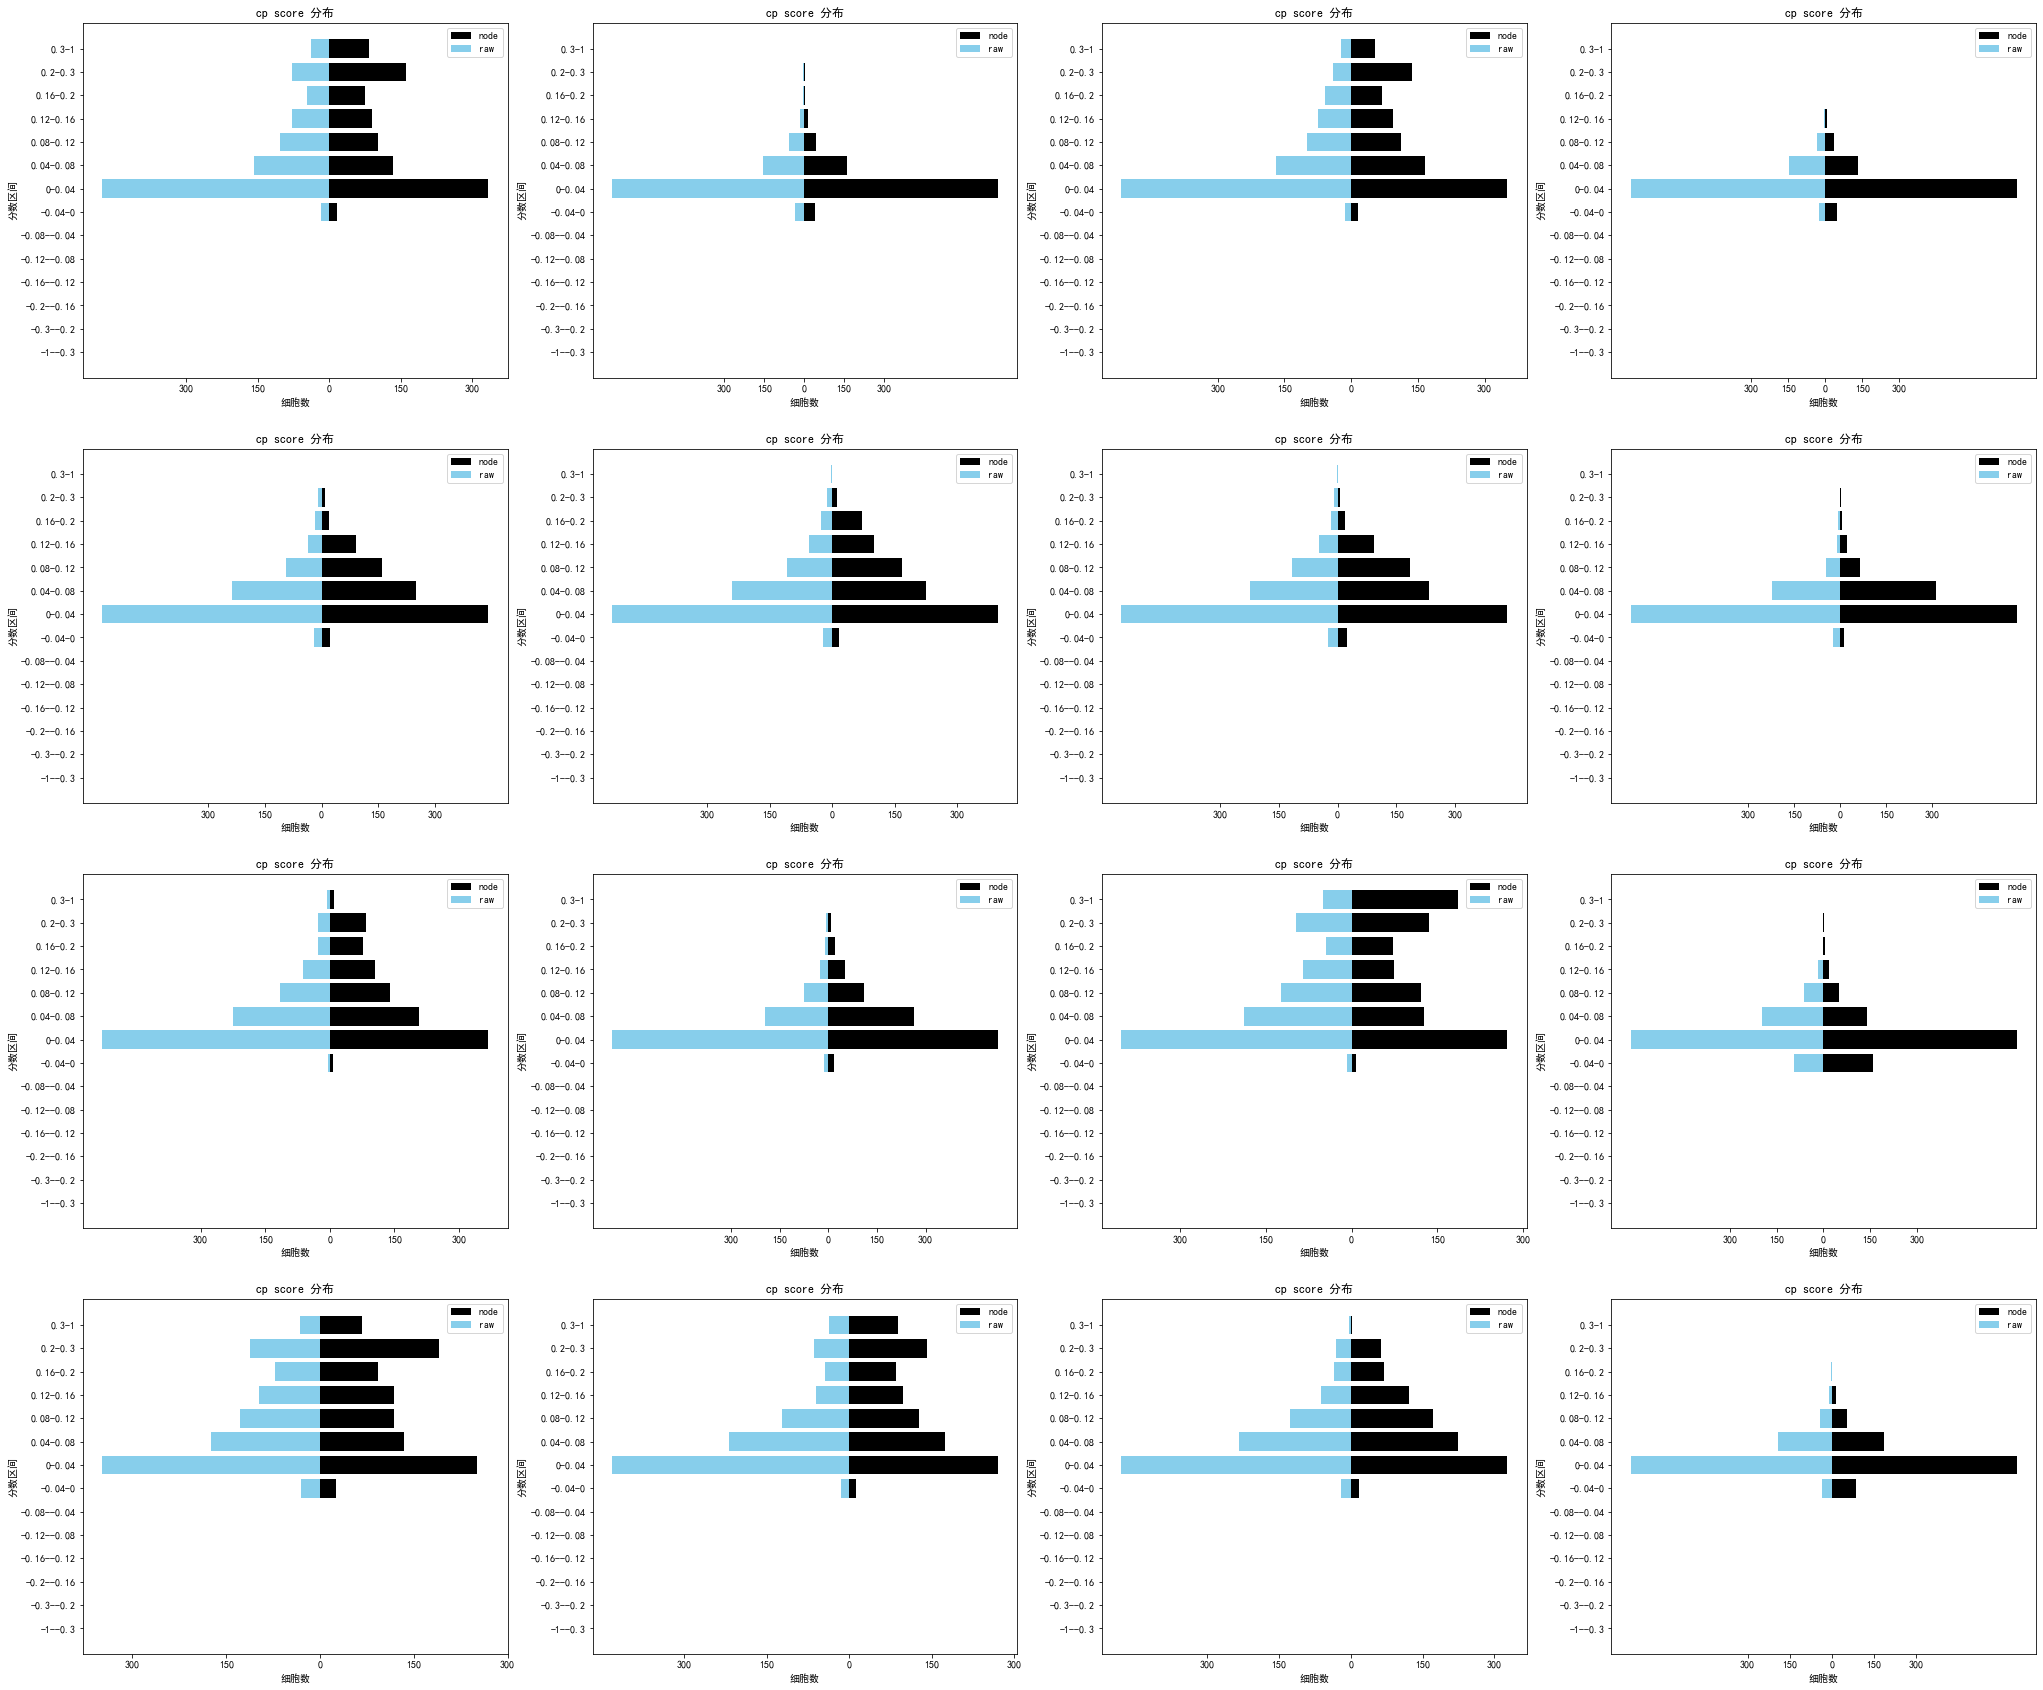

In [8]:
plt.rcParams['font.sans-serif']='SimHei'
plt.rcParams['axes.unicode_minus']=False
df = output
#df=pd.read_csv('output1.csv', index_col= 0)
list_node=df['node'].values.tolist()
bins = [-1, -0.3, -0.2, -0.16, -0.12, -0.08, -0.04, 0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.3, 1]
y = ['-1--0.3', '-0.3--0.2', '-0.2--0.16', '-0.16--0.12', '-0.12--0.08', '-0.08--0.04', '-0.04-0', '0-0.04', '0.04-0.08', '0.08-0.12', '0.12-0.16', '0.16-0.2', '0.2-0.3', '0.3-1']
m = n = 0
fig ,axes = plt.subplots(4,4, figsize=(35,30))
for i in range(1, len(df['node'].loc[0]) - 1):
    l = []
    l2 = []
    for j in df.index:
        l.append(df['node'].loc[j][i])
        l2.append(df['raw'].loc[j][i])
    a = pd.cut(l, bins)
    b = pd.cut(l2, bins)
    #print(a.value_counts())
    ax=axes[m, n]
    ax.barh(y,list(a.value_counts()),label='node',color='black')
    ax.barh(y,[-x for x in list(b.value_counts())],label='raw',color='skyblue')
    ax.set_ylabel("分数区间")
    ax.set_xticks([-300,-150,0,150,300])
    ax.set_xticklabels(['300','150','0','150','300'])
    ax.set_xlabel("细胞数")
    ax.set_title('cp score 分布')
    ax.legend()
    if n < 3:
        n += 1
    else :
        m += 1
        n = 0

plt.show()

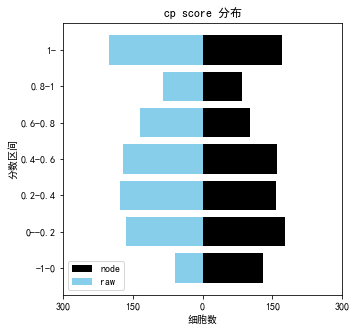

In [12]:
fig ,axes = plt.subplots(1,1, figsize=(5,5))
l = []
l2 = []
l_cell = []
bins = [-0.5, 0, 0.2, 0.4, 0.6, 0.8, 1, 10]
y = ['-1-0', '0--0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1', '1-']
for j in df.index:
    v = 0
    v2 = 0
    for i in range(len(df['node'].loc[0]) - 1):
        v += df['node'].loc[j][i]
        v2 +=df['raw'].loc[j][i]
    l.append(v)
    l2.append(v2)
    if v < 0:l_cell.append(df['cell'].loc[j])
a = pd.cut(l, bins)
b = pd.cut(l2, bins)
ax = axes
ax.barh(y,list(a.value_counts()),label='node',color='black')
ax.barh(y,[-x for x in list(b.value_counts())],label='raw',color='skyblue')
ax.set_ylabel("分数区间")
ax.set_xticks([-300,-150,0,150,300])
ax.set_xticklabels(['300','150','0','150','300'])
ax.set_xlabel("细胞数")
ax.set_title('cp score 分布')
ax.legend()
plt.show()


In [14]:
c = pd.DataFrame(l_cell)

In [16]:
c.to_csv('l_cell.csv')

In [34]:
def get_mat3(file_dir, files, chr, re, type):
    '''
    :param chr:
    :param num:
    :param re:
    :param type:.npz'
    :param output_dir:
    :return:
    '''
    HiC_dir = file_dir + '/lym/HiC_node2vec'
    chr_key = chr
    if Result_record(HiC_dir, chr_key, files[0]):
        raw, node = get_rawandout(files[0], HiC_dir, chr_key, re, type)
    if len(files) > 1 :
        for file in tqdm(files[1:]):
            if Result_record(HiC_dir, chr_key, file):
                r, n = get_rawandout(file, HiC_dir, chr_key, re, type)
        if node.shape == n.shape:
            raw = raw + r
            node = node + n
    if type == '.npz':
        raw = raw.todense()
        node = node.todense()
    return raw, node
l = pd.read_csv('l_cell.csv', index_col=0)
lis = l.iloc[:, 0].tolist()
print(lis)
r, n = get_mat3('D:\\dataset', l_cell, 'chr1', 100000, '.npz')

['DPM6bot1.Odd2Bo25.Even2Bo51', 'DPM6bot1.Odd2Bo43.Even2Bo3', 'DPM6bot11.Odd2Bo81.Even2Bo78', 'DPM6bot12.Odd2Bo54.Even2Bo68', 'DPM6bot12.Odd2Bo95.Even2Bo9', 'DPM6bot13.Odd2Bo75.Even2Bo91', 'DPM6bot14.Odd2Bo39.Even2Bo12', 'DPM6bot15.Odd2Bo31.Even2Bo50', 'DPM6bot17.Odd2Bo30.Even2Bo49', 'DPM6bot18.Odd2Bo23.Even2Bo12', 'DPM6bot18.Odd2Bo61.Even2Bo19', 'DPM6bot18.Odd2Bo73.Even2Bo43', 'DPM6bot18.Odd2Bo76.Even2Bo87', 'DPM6bot18.Odd2Bo78.Even2Bo4', 'DPM6bot2.Odd2Bo21.Even2Bo85', 'DPM6bot2.Odd2Bo64.Even2Bo46', 'DPM6bot2.Odd2Bo79.Even2Bo52', 'DPM6bot2.Odd2Bo94.Even2Bo67', 'DPM6bot2.Odd2Bo95.Even2Bo53', 'DPM6bot20.Odd2Bo10.Even2Bo35', 'DPM6bot20.Odd2Bo61.Even2Bo17', 'DPM6bot20.Odd2Bo72.Even2Bo65', 'DPM6bot20.Odd2Bo95.Even2Bo11', 'DPM6bot22.Odd2Bo55.Even2Bo86', 'DPM6bot22.Odd2Bo81.Even2Bo83', 'DPM6bot22.Odd2Bo87.Even2Bo49', 'DPM6bot23.Odd2Bo37.Even2Bo90', 'DPM6bot23.Odd2Bo62.Even2Bo82', 'DPM6bot24.Odd2Bo43.Even2Bo53', 'DPM6bot24.Odd2Bo60.Even2Bo14', 'DPM6bot24.Odd2Bo70.Even2Bo49', 'DPM6bot25.Odd2Bo

100%|██████████| 137/137 [00:07<00:00, 18.67it/s]


In [35]:
from higashi import get_scc2
all = np.loadtxt('norm_raw_all_100000.matrix')
a1, b1 = get_scc2(all, n, 180000000//100000)
a2, b2 = get_scc2(all, r, 180000000//100000)
a1, a2

(0.09123307288901045, 0.051478195547819336)

(0.09123307288901045, 0.051478195547819336)

In [36]:
import matplotlib.gridspec as gridspec
from higashi import zscore_norm
def fig_chr_heatmap(all_matrix, out_matrix, raw_out_matrix):
    plt.figure(figsize=(30, 11))
    widths = [10, 10, 10]
    heights = [10, 1]
    gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=widths,height_ratios=heights)
    #data = np.tril(out_matrix, k=0) + np.triu(raw_out_matrix, k=0)
    ax1 = plt.subplot(gs[0, 0])
    ax1.matshow(all_matrix, cmap='YlOrRd', vmin=0, vmax=0.15)
    ax1.set_title('all', fontdict={'fontsize': 20, 'fontweight': 'medium'})
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax2 = plt.subplot(gs[0, 1])
    ax2.matshow(out_matrix, cmap='YlOrRd', vmin=-1, vmax=1)
    ax2.set_title('out:scc=0.09', fontdict={'fontsize': 20, 'fontweight': 'medium'})
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax3 = plt.subplot(gs[0, 2])
    ax3.matshow(raw_out_matrix, cmap='YlOrRd', vmin=0, vmax=1.5)
    ax3.set_title('raw:scc=0.05', fontdict={'fontsize': 20, 'fontweight': 'medium'})
    ax3.set_xticklabels([])
    ax3.set_yticklabels([])
    plt.savefig('1.jpg')
    plt.show()


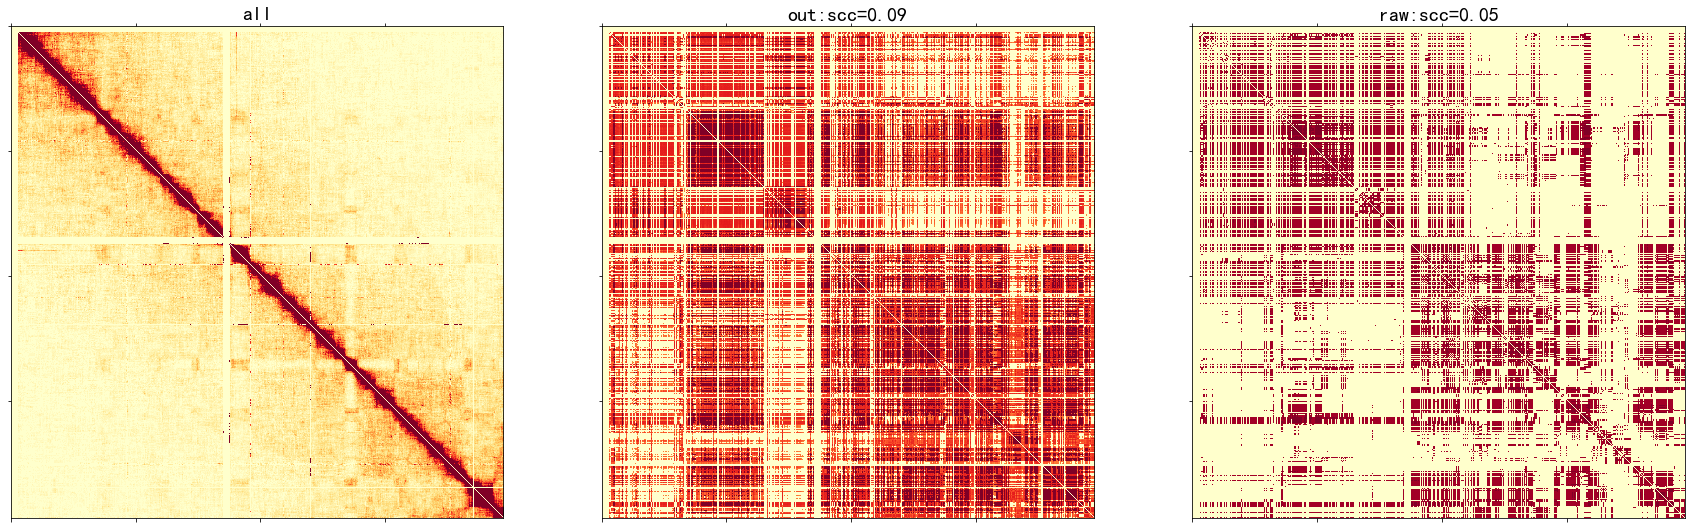

In [37]:
n = zscore_norm(np.array(n))
r = zscore_norm(np.array(r))

fig_chr_heatmap(all, n, r)

In [8]:
import os
from scipy import sparse
def make_file(mat, re, output_dir, output_name):
    mat = mat.todense()
    pos1, pos2 = mat.nonzero()
    columns = ['str1', 'chr1', 'x1', 'frag1', 'str2', 'chr2', 'x2', 'frag2', 'score']
    index = [i for i in range(len(pos2))]
    #index = [i for i in range(100)]
    d = []
    for i in tqdm(range(len(pos2))):
        d.append([0, 'chr1', pos1[i] * re, 0, 1, 'chr1', pos2[i] * re, 1, mat[pos1[i], pos2[i]]])
    data = pd.DataFrame(d, columns=columns, index=index)
    data.to_csv(output_dir + '\\' + output_name + '.hic.input',index = False, header = None, sep = "\t")

'''if __name__ == '__main__':
    mat = sparse.load_npz('D:\\py_project\\HiC_node2vec\\data\\node_200_chr4_10000.npz')
    re = 10000
    output_dir = 'D:\\py_project\\HiC_node2vec\\data'
    output_name = 'chrnode10000'
    make_file(mat, re, output_dir, output_name)
    print('done')'''

"if __name__ == '__main__':\n    mat = sparse.load_npz('D:\\py_project\\HiC_node2vec\\data\\node_200_chr4_10000.npz')\n    re = 10000\n    output_dir = 'D:\\py_project\\HiC_node2vec\\data'\n    output_name = 'chrnode10000'\n    make_file(mat, re, output_dir, output_name)\n    print('done')"

In [22]:
def make_4DN(files, re, name):
    d = []
    d2 = []
    l = 0
    l2 = 0
    for t in tqdm(range(len(files))):
        file = files[t]
        mat = sparse.load_npz('D:\\dataset\\lym\\HiC_node2vec\\' + file + '\\chr1\\' + file + '_chr1.npz')
        mat2 = sparse.load_npz('D:\\dataset\\lym\\HiC_node2vec\\' + file + '\\chr1\\' + 'raw_chr1.npz')
        mat = mat.todense()
        mat2 = mat2.todense()
        pos1, pos2 = mat.nonzero()
        pos3, pos4 = mat2.nonzero()
        columns = ['cell_id',	'chrom1',	'chrom2',	'pos1',	'pos2',	'count',	'normalized_count']
        for i in (range(len(pos2))):
            d.append([t, 'chr1', 'chr1', pos1[i] * re, pos2[i] * re, mat[pos1[i], pos2[i]], mat[pos1[i], pos2[i]]])
        for i in range(len(pos3)):
            d2.append([t, 'chr1', 'chr1', pos3[i] * re, pos4[i] * re, mat[pos3[i], pos4[i]], mat[pos3[i], pos4[i]]])
        l += len(pos2)
        l2 +=len(pos3)
    index = [i for i in range(l)]
    index2 = [i for i in range(l2)]
    data = pd.DataFrame(d, columns=columns, index=index)
    data2 = pd.DataFrame(d2, columns=columns, index=index2)
    data.to_csv('node_4DN' + name + '.txt',index = False, sep = "\t")
    data2.to_csv('raw_4DN' + name + '.txt',index = False, sep = "\t")
files = randomfile('D:\\dataset', 1000)
for file in l_cell:
    files.remove(file)
len(files)

858

In [24]:
make_4DN(files[0:200], 100000, '100-200')

100%|██████████| 200/200 [05:41<00:00,  1.71s/it]


In [33]:
from notebook.auth import passwd

In [34]:
passwd()

'argon2:$argon2id$v=19$m=10240,t=10,p=8$krHIRNpyw5+NJSyfnAKpxg$Gn2HtZXTGcqqAgWmFf8rVtkkDyb+5qxpfTFH02oG1wE'

In [ ]:
'argon2:$argon2id$v=19$m=10240,t=10,p=8$krHIRNpyw5+NJSyfnAKpxg$Gn2HtZXTGcqqAgWmFf8rVtkkDyb+5qxpfTFH02oG1wE'